## Import Libraries

In [1]:
import re
import pandas as pd 
import numpy as np 
np.random.seed(42)

import sklearn
from sklearn.metrics import classification_report

import tensorflow as tf

import html
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt 
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

import multiprocessing as mp

import warnings 
import os
warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/justineclemente/programs/anaconda3/envs/python3_tf1.14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/justineclemente/programs/anaconda3/envs/python3_tf1.14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/justineclemente/programs/anaconda3/envs/python3_tf1.14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.d

In [2]:
df = pd.read_csv("../datasets/imdb.csv")

In [3]:
df.head()

,review,sentiment,tagalog
0,"A very, very, very slow-moving, aimless movie ...",0,"Isang napaka, napaka, napaka-mabagal na gumala..."
1,Not sure who was more lost - the flat characte...,0,Hindi sigurado kung sino ay mas maraming mawaw...
2,Attempting artiness with black & white and cle...,0,Sinusubukang artiness na may itim at puti at m...
3,Very little music or anything to speak of.,0,Napakaliit na musika o anumang bagay upang mag...
4,The best scene in the movie was when Gerardo i...,1,Ang pinakamahusay na mga eksena sa pelikula ay...


### Exploratory Data Analysis on the Dataset

In [4]:
df['sentiment'].value_counts()

1    500
0    500
Name: sentiment, dtype: int64

In [6]:
print(df["review"][420])

It just blew.


In [7]:
print(df["tagalog"][420])

Ito ay lamang blew.


We can see in this dataset that the ```tagalog``` column is just the tagalog-translated version of the ```reviews``` column. Therefore, we have 2 representations of each sentence(tagalog and english) with their corresponding sentiment.

We create a combined dataset of tagalog and english sentences so we can use a stratified sampling in creating the ```train and test data```

In [8]:
df_tagalog = df[["tagalog","sentiment"]]
df_tagalog["language"] = "tagalog"
df_tagalog = df_tagalog.rename(columns={"tagalog": "review"})
df_english = df[["review","sentiment"]]
df_english["language"] = "english"

df_final = df_tagalog.append(df_english)
df_final.reset_index(inplace=True,drop=True)
df_final

,review,sentiment,language
0,"Isang napaka, napaka, napaka-mabagal na gumala...",0,tagalog
1,Hindi sigurado kung sino ay mas maraming mawaw...,0,tagalog
2,Sinusubukang artiness na may itim at puti at m...,0,tagalog
3,Napakaliit na musika o anumang bagay upang mag...,0,tagalog
4,Ang pinakamahusay na mga eksena sa pelikula ay...,1,tagalog
...,...,...,...
1995,I just got bored watching Jessice Lange take h...,0,english
1996,"Unfortunately, any virtue in this film's produ...",0,english
1997,"In a word, it is embarrassing.",0,english
1998,Exceptionally bad!,0,english


In [9]:
len(df_final)

2000

### Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_final["review"], df_final["sentiment"], test_size=0.20, random_state=42, stratify=df_final[["language","sentiment"]])

## Pre-Processing
- Remove HTML Tags
- Removing Twitter handles (@) and Hashtags(#)
- Convert contractions
- Remove time formats
- Remove special characters
- Tokenization
- Removal of Stopwords

In [11]:
def removeURLs(message) :

    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', message)

    dictOfurls = { i : 5 for i in urls }
    dictOfurls = dict(map(lambda x: (x[0],''), dictOfurls.items() ))

    for k, v in dictOfurls.items():
        message = message.replace(k, v)

    return message

In [12]:
def removeURLs2(message) :

    urls = re.findall('www.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', message)

    dictOfurls = { i : 5 for i in urls }
    dictOfurls = dict(map(lambda x: (x[0],''), dictOfurls.items() ))

    for k, v in dictOfurls.items():
        message = message.replace(k, v)

    return message

In [13]:
fname = '../datasets/stopwords.txt'

with open(fname) as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content]

In [14]:
# create the function for removing the stop words
def remove_stop_words(s):
    s_cleaned=[]
    for w in s:
        if len(w)>=3 and w.lower() not in set(stopwords.words('english')).union(set(content)):
            s_cleaned.append(w.strip())
    return s_cleaned

In [15]:
def preprocessing(text):
    #Remove and convert HTML Tags
    html_test = html.unescape(text)
    soup = BeautifulSoup(re.sub(r'[\n\r]', ' ', html_test))
    
    t2 = soup.get_text()
    
    #Removing Twitter handles before removing the URLs
    t2 = re.sub(r"(@\S+)*", "", t2)

    #Remove the URLs
    t2 = removeURLs(t2)
    t2 = removeURLs2(t2)

    #Remove remaining https://
    t2 = re.sub(r"https://", '', t2)

    #Remove 't
    t2 = re.sub(r"'nt", ' not', t2)
    t2 = re.sub(r"'t", ' not', t2)

    #Remove Twitter #s
    t2 = re.sub(r"(#\S+)*", "", t2)

    #Time Cleaning
    t2 = re.sub(r'\d*:\d+\s([aApP][mM])', '', t2)
    t2 = re.sub(r'\d*:\d+([aApP][mM])', '', t2)
    t2 = re.sub(r'\d+\s?([aApP][mM])', '', t2)
    t2 = re.sub(r'\d+:\d+', '', t2)

    #Special Character Cleaning
    t2 = re.sub(r"( -+ )", " ",t2)
    t2 = " ".join([re.sub(r'[^A-Za-zñ-]+', ' ', x) for x in t2.split()])
    t2 = re.sub(r"( - )", " ", t2)
    t2 = re.sub(r"(\s-\w+)", " ", t2)
    t2 = re.sub(r"(\w+-\s)", " ", t2)
    t2 = re.sub(r"( \w )", " ", t2)
    
    #tokenization and removal of stop words
    t2 = word_tokenize(t2)
    t2_clean = remove_stop_words(t2)
    
    return t2_clean

### Apply Pre-Processing on Training and Test Data

#### Text Cleaning

In [16]:
X_train_cleaned = X_train.apply(preprocessing)
X_train.head()

1275    The performances are real and gripping, the cr...
1219        Hence the whole story lacks a certain energy.
271     Hanggang doon na may ang pinakamahusay na ng M...
299     Hindi ko sa tingin ng isang mas mahusay na par...
1153                                  No plot whatsoever!
Name: review, dtype: object

In [17]:
X_test_cleaned = X_test.apply(preprocessing)
X_test.head()

319      At ko talagang ginawa mahanap ang mga ito funny.
1966    Each track commands sentiment, actually contri...
1799    How this piece of trash was ever released is b...
232        Ang karakter developments din lacked sa depth.
317     Ang pagkumpuni ng telepono ng tao ay talagang ...
Name: review, dtype: object

In [18]:
### if you have lots of data, you can also use multiprocessing
pool = mp.Pool(processes=mp.cpu_count()-1)
X_train_cleaned=pool.map(preprocessing,X_train)
X_test_cleaned=pool.map(preprocessing,X_test)

### Optional: Word Cloud for each labels

#### Word Cloud for Negative Labels

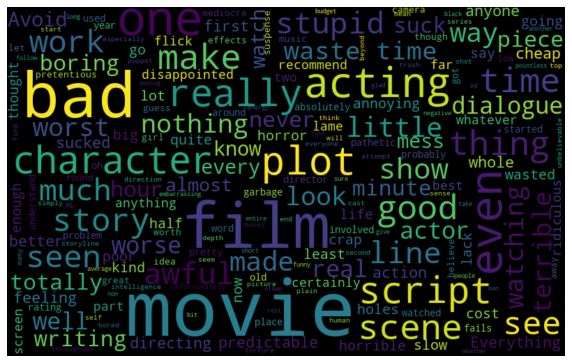

In [19]:
normal_words =' '.join([text for text in df['review'][df['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Word Cloud for Positive Labels

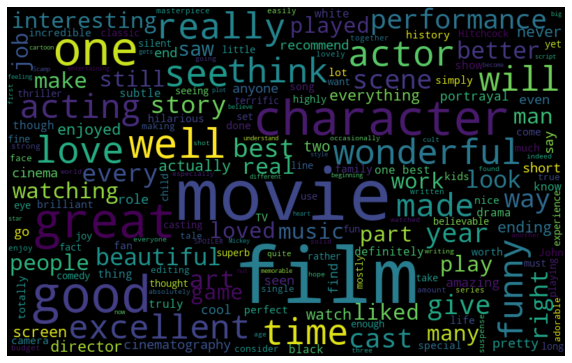

In [20]:
normal_words =' '.join([text for text in df['review'][df['sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Creation of word2index

In [21]:
words = set([])
 
for s in X_train_cleaned:
    for w in s:
        words.add(w.lower())


word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs

In [22]:
import json

json.dump(word2index, open("../models/word2index.json", 'w' ))

## Feature Text Extraction
- In a deeplearning approach in NLP, Word Embeddings are used. 
- Normally, Word2Vec  is sufficient but in Filipino texts, FastText is more effective.
- Try to do 2 different approaches, both using FastText and Word2Vec

### FastText Approach

In [23]:
#Declare Model Parameters
cbow = 0
skipgram = 1
EMB_DIM = 300 #more dimensions, more computationally expensive to train
min_word_count = 3
workers = mp.cpu_count()-1 #based on computer cpu count
context_size = 5
downsampling = 1e-3
learning_rate = 0.025 #initial learning rate
min_learning_rate = 0.025 #fixated learning rate
num_epoch = 8

In [ ]:
from gensim.models import FastText

fasttext = FastText(
    sg = skipgram,
    hs = 0, #hierarchical softmax
    negative = 10,
    size = EMB_DIM,
    min_count = min_word_count, 
    workers = workers,
    window = context_size, 
    sample = downsampling, 
    alpha = learning_rate, 
    min_alpha = min_learning_rate,
    seed=1,
    word_ngrams=3
)
print('Vocabulary size: %d' % len(words))
fasttext.build_vocab(X_train_cleaned)
fasttext.train(X_train_cleaned,epochs=num_epoch,total_examples=fasttext.corpus_count)
words_fasttext = list(fasttext.wv.vocab)
print("Vocabulary Size after FastText:",len(words_fasttext))
filename = '../models/embedding_fasttext.txt'
fasttext.wv.save_word2vec_format(filename, binary=False)

### Word2Vec Approach

In [30]:
#Declare Model Parameters
cbow = 0
skipgram = 1
EMB_DIM = 300 #more dimensions, more computationally expensive to train
min_word_count = 2
workers = mp.cpu_count()-1 #based on computer cpu count
context_size = 5
downsampling = 1e-3
learning_rate = 0.025 #initial learning rate
min_learning_rate = 0.025 #fixated learning rate
num_epoch = 8

In [31]:
from gensim.models import Word2Vec

word2vec = Word2Vec(
    sg = skipgram,
    hs = 0, #hierarchical softmax
    negative = 10,
    size = EMB_DIM,
    min_count = min_word_count, 
    workers = workers,
    window = context_size, 
    sample = downsampling, 
    alpha = learning_rate, 
    min_alpha = min_learning_rate,
    seed=1,
)
print('Vocabulary size: %d' % len(words))
word2vec.build_vocab(X_train_cleaned)
word2vec.train(X_train_cleaned,epochs=num_epoch,total_examples=word2vec.corpus_count)
words_word2vec = list(word2vec.wv.vocab)
print("Vocabulary Size after Word2Vec:",len(words_word2vec))
filename = '../models/embedding_word2vec.txt'
word2vec.wv.save_word2vec_format(filename, binary=False)

Vocabulary size: 4313
Vocabulary Size after Word2Vec: 2051


Create Embeddings Index

In [32]:
embeddings_index={}
f=open('../models/embedding_word2vec.txt',encoding="utf-8")
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close()

### Padding of Sentences

In [33]:
train_sentences_X, test_sentences_X = [], []

num_words=len(word2index)+1
embedding_matrix=np.zeros((num_words,EMB_DIM))
for word,i in word2index.items():
    if i>num_words:
        continue
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

for s in X_train_cleaned:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    train_sentences_X.append(s_int)
    
for s in X_test_cleaned:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    test_sentences_X.append(s_int)


MAX_LENGTH = len(max(train_sentences_X, key=len))
print(MAX_LENGTH)  # 271

from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
y_train = y_train.values
y_test = y_test.values

print(train_sentences_X[0])

42
[2955 2738 2265 4135 1927 1228 2114 1234 2746  738  637  257  114 2738
 3479 4078 2905 1184    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


Using TensorFlow backend.


## Training the Model
- Use Keras Subclassing API rather than the Sequential API for flexibility

In [34]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 42)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 42, 300)           1294800   
_________________________________________________________________
bidirectional (Bidirect

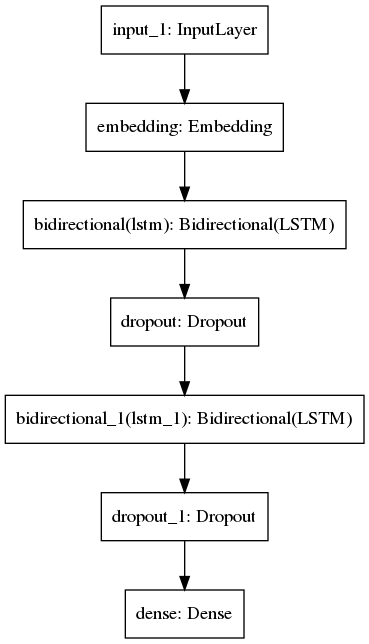

In [35]:
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, Embedding, Activation,Dropout,Input,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model,Sequential

inputs = Input(shape=(MAX_LENGTH,))
embedding_layer = Embedding(num_words,EMB_DIM,embeddings_initializer=Constant(embedding_matrix),input_length=MAX_LENGTH,trainable=True,mask_zero=True)
lstm_model = embedding_layer(inputs)
lstm_model = Bidirectional(LSTM(256,activation="tanh",return_sequences=True,recurrent_dropout=0.3,kernel_initializer='random_uniform'))(lstm_model)
lstm_model = Dropout(0.3)(lstm_model)
lstm_model = Bidirectional(LSTM(256,activation="tanh",recurrent_dropout=0.3,kernel_initializer='random_uniform'))(lstm_model)
lstm_model = Dropout(0.3)(lstm_model)
predictions = Dense(1,activation="sigmoid")(lstm_model)
lstm_model=Model(inputs=inputs,outputs=predictions)
lstm_model.compile(loss='binary_crossentropy',
              optimizer=Adam(0.001),    
              metrics=["accuracy",recall_m,precision_m,f1_m])
print(lstm_model.summary())
plot_model(lstm_model, to_file='../models/lstm_model.png')

### Train the Model

* In this code block, ```EarlyStopping``` and ```Model Checkpoint`` is used. 
* EarlyStopping is used to stop the training of the model early if it does not detect any improvements.
* You can use multiple EarlyStopping in one training, in this case, EarlyStopping is used to monitor ```validation accuracy, f1-score, loss```, if it does not detect any improvements with these values, the training will stop.
* ModelCheckpoint is used to track and save the model with the best metric performance. 
* ModelCheckpoint will monitor ```val_acc``` in each epoch, and will save the model with the highest ```val_acc```

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import os 
es_valacc = EarlyStopping(monitor='val_acc', mode='max',verbose=1,patience=5,min_delta=0.003)
es_f1 = EarlyStopping(monitor='val_f1_m', mode='max',verbose=1,patience=7,min_delta=0.003)
es_loss = EarlyStopping(monitor='loss', mode='min',verbose=1,min_delta=0.003,patience=5)
save = ModelCheckpoint('../models/best_model_lstm_train.hdf5', save_best_only=True, monitor='val_acc', mode='max')
history_lstm=lstm_model.fit(train_sentences_X, y_train, validation_split=0.2, batch_size=64,epochs=20,callbacks=[save,es_loss,es_valacc,es_f1])

Train on 1280 samples, validate on 320 samples
Epoch 1/20
1280/1280 [==============================] - 25s 19ms/sample - loss: 0.6917 - acc: 0.5227 - recall_m: 0.5144 - precision_m: 0.4186 - f1_m: 0.4432 - val_loss: 0.6867 - val_acc: 0.5375 - val_recall_m: 0.2999 - val_precision_m: 0.6086 - val_f1_m: 0.3976
Epoch 2/20
1280/1280 [==============================] - 15s 12ms/sample - loss: 0.6684 - acc: 0.5953 - recall_m: 0.4340 - precision_m: 0.6880 - f1_m: 0.4604 - val_loss: 0.6340 - val_acc: 0.5938 - val_recall_m: 0.2125 - val_precision_m: 0.9300 - val_f1_m: 0.3401
Epoch 3/20
1280/1280 [==============================] - 15s 11ms/sample - loss: 0.3628 - acc: 0.8992 - recall_m: 0.8787 - precision_m: 0.9296 - f1_m: 0.8952 - val_loss: 1.2012 - val_acc: 0.7188 - val_recall_m: 0.9149 - val_precision_m: 0.6603 - val_f1_m: 0.7657
Epoch 4/20
1280/1280 [==============================] - 15s 12ms/sample - loss: 0.1183 - acc: 0.9609 - recall_m: 0.9560 - precision_m: 0.9673 - f1_m: 0.9601 - val_loss

### Save the Model

In [37]:
dependencies = {
    'precision_m': precision_m,
    'recall_m': recall_m,
    'f1_m': f1_m
}

model_lstm=tf.keras.models.load_model("../models/best_model_lstm_train.hdf5",custom_objects=dependencies)
scores = model_lstm.evaluate(test_sentences_X,y_test)
print(model_lstm.metrics_names)
print(scores)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
400/400 [==============================] - 3s 7ms/sample - loss: 0.6279 - acc: 0.7925 - recall_m: 0.8380 - precision_m: 0.7689 - f1_m: 0.7989
['loss', 'acc', 'recall_m', 'precision_m', 'f1_m']
[0.6279261755943298, 0.7925, 0.83803093, 0.7689382, 0.7988921]


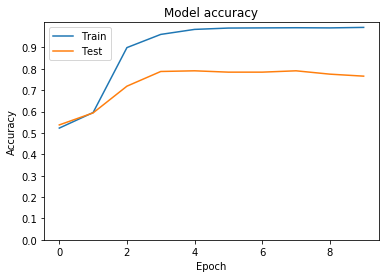

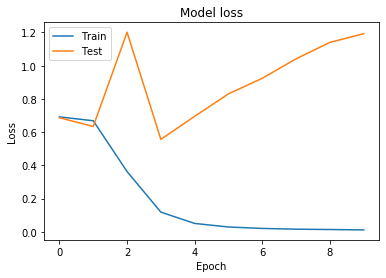

In [38]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(history_lstm.history['acc'])
plt.plot(history_lstm.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.yticks(np.arange(0,1,step=0.1))
plt.savefig("acc_lstm.png")

plt.figure( )
# Plot training & validation loss values
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("loss_lstm.png")